In [2]:
import numpy as np 
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import random
from time import process_time # to time processes by time scales and not # of iterations

In [3]:
def sphere(x):
    return x.dot(x)
def rastrigin(x):
    return 10*len(x)+sum(x**2-10*np.cos(2*np.pi*x))

In [4]:
class ParticleA: # all the material that is relavant at the level of the individual particles
    
    def __init__(self, dim, minx, maxx, funct):
        self.position = np.random.uniform(low=minx, high=maxx, size=dim)
        self.velocity = np.random.uniform(low=-0.1, high=0.1, size=dim)
        self.best_particle_pos = self.position
        self.dim = dim
        self.funct=funct
        self.fitness = self.funct(self.position)
        self.best_particle_fitness = self.fitness   # we couldd start with very large number here, 
                                                    #but the actual value is better in case we are lucky 
                
    def setPos(self, pos):
        self.position = pos
        self.fitness = self.funct(pos)  #WATCH OUT WITH THIS LINE: Is it self.position or just pos?
        
        if self.fitness<self.best_particle_fitness:     # to update the personal best both 
                                                        # position (for velocity update) and
                                                        # fitness (the new standard) are needed
                                                        # global best is update on swarm leven
            self.best_particle_fitness = self.fitness
            self.best_particle_pos = pos

    def updateVel(self, inertia, a1, a2, best_self_pos, best_swarm_pos):
                # Here we use the canonical version
                # V <- inertia*V + a1r1 (peronal_best - current_pos) + a2r2 (global_best - current_pos)
        cur_vel = self.velocity
        r1 = np.random.uniform(low=0, high=1, size = self.dim)
        r2 = np.random.uniform(low=0, high=1, size = self.dim)
        a1r1 = np.multiply(a1, r1)
        a2r2 = np.multiply(a2, r2)
        best_self_dif = np.subtract(best_self_pos, self.position)
        best_swarm_dif = np.subtract(best_swarm_pos, self.position)
                    # the next line is the main equation, namely the velocity update, 
                    # the velocities are added to the positions at swarm level
        new_vel = inertia*cur_vel + np.multiply(a1r1, best_self_dif) + np.multiply(a2r2, best_swarm_dif)
        self.velocity = new_vel
        return new_vel
    
    

#In these lines of codes, I add another argument to the particle class created in the labs, which determines the function in which our swarm particles are evaluated. 
#Hence, when optimising a particular function f, we will call our particles with funct=f.

In [5]:
class ParticleB: # all the material that is relavant at the level of the individual particles
    
    def __init__(self, dim, minx, maxx, funct):
        self.position = np.random.uniform(low=minx, high=maxx, size=dim)
        self.velocity = np.random.uniform(low=-0.1, high=0.1, size=dim)
        self.best_particle_pos = self.position
        self.dim = dim
        self.funct=funct
        self.fitness = self.funct(self.position)
        self.best_particle_fitness = self.fitness   # we couldd start with very large number here, 
                                                    #but the actual value is better in case we are lucky 
                
    def setPos(self, pos):
        self.position = pos
        self.fitness = self.funct(pos)  #WATCH OUT WITH THIS LINE: IS IT self.position or just pos?
        
        if self.fitness<self.best_particle_fitness:     # to update the personal best both 
                                                        # position (for velocity update) and
                                                        # fitness (the new standard) are needed
                                                        # global best is update on swarm leven
            self.best_particle_fitness = self.fitness
            self.best_particle_pos = pos

    def updateVel(self, inertia, a1, a2, best_self_pos, best_swarm_pos):
                # Here we use the canonical version
                # V <- inertia*V + a1r1 (peronal_best - current_pos) + a2r2 (global_best - current_pos)
        cur_vel = self.velocity
        r1 = np.random.uniform(low=0, high=1, size = self.dim)
        r2 = np.random.uniform(low=0, high=1, size = self.dim)
        a1r1 = np.multiply(a1, r1)
        a2r2 = np.multiply(a2, r2)
        best_self_dif = np.subtract(best_self_pos, self.position)
        best_swarm_dif = np.subtract(best_swarm_pos, self.position)
                    # the next line is the main equation, namely the velocity update, 
                    # the velocities are added to the positions at swarm level
        new_vel = inertia*cur_vel + np.multiply(a1r1, best_self_dif) + np.multiply(a2r2, best_swarm_dif)
        self.velocity = new_vel
        return new_vel

#In these lines of codes, I add another argument to the particle class created in the labs, which determines the function in which our swarm particles are evaluated. 
#Hence, when optimising a particular function f, we will call our particles with funct=f.

In [6]:
class HetPSO: # all the material that is relavant at swarm leveel

    def __init__(self, wA, aA1, aA2, wB, aB1, aB2, dim, population_size, search_range, f, termination, max_num_iterations):

        # Here we use values that are (somewhat) known to be good
        # There are no "best" parameters (No Free Lunch), so try using different ones
        # There are several papers online which discuss various different tunings of a1 and a2
        # for different types of problems
        
        self.wA = wA # Inertia class A particles
        self.aA1 = aA1 # Attraction to personal best of swarm A
        self.aA2 = aA2 # Attraction to global best of swarm A
        
        self.wB = wB # Inertia class B particles
        self.aB1 = aB1 # Attraction to personal best of swarm B
        self.aB2 = aB2 # Attraction to global best of swarm B
        
        self.dim = dim
        self.f=f
        self.termination=termination # a termination threeshold.
        self.population_A=population_size//2
        self.population_B=population_size-self.population_A
        self.swarmA = [ParticleA(dim,-search_range,search_range, self.f) for i in range(self.population_A)]
        self.swarmB=[ParticleB(dim,-search_range,search_range, self.f) for i in range(self.population_B)]
        self.swarms=[self.swarmA, self.swarmB]

        # Initialising global best, you can wait until the end of the first time step
        # but creating a random initial best and fitness which is very high will mean you
        # do not have to write an if statement for the one off case
        self.best_swarmA_pos = np.random.uniform(low=-500, high=500, size=dim)
        self.best_swarmA_fitness = 1e100
        
        self.best_swarmB_pos = np.random.uniform(low=-500, high=500, size=dim)
        self.best_swarmB_fitness = 1e100
        
        self.max_num_iterations=max_num_iterations
        

    def run(self): 
        time=0
        diver=0
        while self.best_swarmA_fitness>self.termination and self.best_swarmB_fitness>self.termination:
            time=time+1
            if time==self.max_num_iterations: 
                    return [None,1]# To avoid to much time running.
                
            for p in range(len(self.swarmA)):
                particle = self.swarmA[p]

                new_position = particle.position + particle.updateVel(self.wA, self.aA1, self.aA2, particle.best_particle_pos, self.best_swarmA_pos)
                                
                if new_position.dot(new_position) > 1.0e+18: # The search will be terminated if the distance 
                                                        # of any particle from center is too large
                        # We would want parameters for which our swarm does not diverge. As we also do not want 
                        # parameter settings producing time consuming runs, we group these two options by making divergent swarms look as time consuming runs
                        #print('Time:', time,'Best Pos:',self.best_swarm_pos,'Best Fit:',self.best_swarm_fitness)
                        #This will tell us whether the swarm diverged or not.
                        #'Most likely divergent: Decrease parameter values'
                    return [None, 1] #if our new particle position is too far apart, we simply return a None time value and a 1 divergence value.
                        #This will state that most likely our swarm diverged and consequently there is no proper convergence of the swarm.
                
                self.swarmA[p].setPos(new_position)         #When executing this recall that you are also maybe updating the value of the particle's best.

                new_fitness = self.f(new_position)

                if new_fitness < self.best_swarmA_fitness:   # to update the global best both 
                                                            # position (for velocity update) and
                                                            # fitness (the new group norm) are needed
                    self.best_swarmA_fitness = new_fitness
                    self.best_swarmA_pos = new_position
                    
            for p in range(len(self.swarmB)):
                particle = self.swarmB[p]

                new_position = particle.position + particle.updateVel(self.wB, self.aB1, self.aB2, particle.best_particle_pos, self.best_swarmB_pos)
                                
                if new_position.dot(new_position) > 1.0e+18: # The search will be terminated if the distance 
                                                        # of any particle from center is too large
                        # We would want parameters for which our swarm does not diverge. As we also do not want 
                        # parameter settings producing time consuming runs, we group these two options by making divergent swarms look as time consuming runs
                        #print('Time:', time,'Best Pos:',self.best_swarm_pos,'Best Fit:',self.best_swarm_fitness)
                        #This will tell us whether the swarm diverged or not.
                        #'Most likely divergent: Decrease parameter values'
                    return [None, 1] #if our new particle position is too far apart, we simply return a None time value and a 1 divergence value.
                        #This will state that most likely our swarm diverged and consequently there is no proper convergence of the swarm.
                
                self.swarmB[p].setPos(new_position)         #When executing this recall that you are also maybe updating the value of the particle's best.

                new_fitness = self.f(new_position)

                if new_fitness < self.best_swarmB_fitness:   # to update the global best both 
                                                            # position (for velocity update) and
                                                            # fitness (the new group norm) are needed
                    self.best_swarmB_fitness = new_fitness
                    self.best_swarmB_pos = new_position
             
                
        return [time, diver]
                
# review time and diver variables.


In [6]:
HetPSO(0.7,2,2,0.3,1,1,9,100,5.12,rastrigin,0.0001,3000).run()
# we can try to have a more exploitative swarm and a exploratory one (basing ourselves in the ones performing well in the sphere and rastrigin)
# or we can use two exploitative swarms or two exploratory ones.
# the above for instance is a mix of exploratory swarm and exploitatory one.
# we will maintain the swarm sizes to 50 by setting the total population size to 100 as it was shown in ex 2 that 50 is still beneficial


[1771, 0]

In [69]:
times=list()
seconds=list()
undesired=list()
for dimension in [1,2,3,4,5,6,7,8,9,10]:
    for max_num_iterations in [1000,2000,3000,4000]:
        c=0
        sumatimes=0
        sumaundesired=0
        sumaseconds=0
        for it in range(300): #the average time we take will be taken over 300 sets
            print("u")
            t_start=process_time() #for timing in seconds
            results=HetPSO(0.3, 1., 1., 0.7, 2, 2, dimension, 50, 5.12, rastrigin, 0.00001,max_num_iterations).run()
            t_stop=process_time()
            
            time, diver=results
            
            if time==None: 
                summaundesired=sumaundesired+1
            else: 
                sumatimes=sumatimes+time
                sumaseconds=sumaseconds+t_stop-t_start
                c=c+1
                
        averagetime=sumatimes/(c+0.00000000001)#the 0.0000000001 is added to avoid division by 0.
        averageseconds=sumaseconds/(c+0.00000000001)# average seconds per run 
        averageundesired=sumaundesired/300
    
        times.append(averagetime)
        seconds.append(averageseconds)
        undesired.append(averageundesired)
    

        
# idea: while maintaining the initial parameters of ex 1 which performed good on the sphere and rastrigin in the two swarms 
# and having each of the swarms of size 50 (optimal by ex 2). 
# we can vary the dimension and the max_num_iterations (effectivelly the total number of fitness evaluations)
# and while recording proportion of undesired events, average iteration times and average second times 
# measurethe performance of the heterogeneous particle swarm optimization

u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u


u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u


u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u
u


<IPython.core.display.Javascript object>


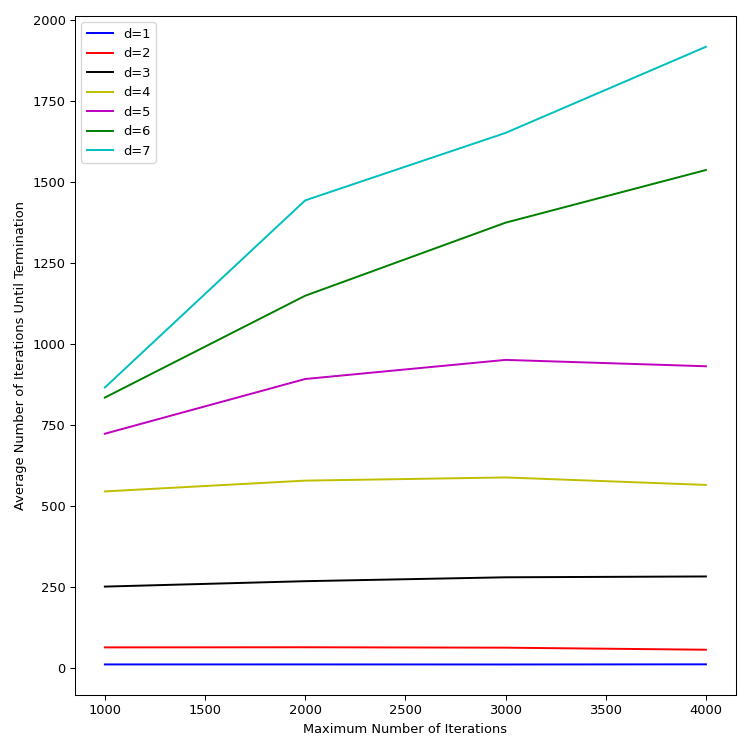

(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:xlabel='Maximum Number of Iterations', ylabel='Average Number of Iterations Until Termination'>)

In [70]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.plot([1000,2000,3000,4000], np.array(times)[:4], '-b', ms=15, label="d=1")#for dimension 1
ax.set_xlabel('Maximum Number of Iterations')
ax.set_ylabel('Average Number of Iterations Until Termination')

ax.plot([1000,2000,3000,4000], np.array(times)[4:8], '-r', ms=15, label="d=2")#for dimension 1
ax.set_xlabel('Maximum Number of Iterations')
ax.set_ylabel('Average Number of Iterations Until Termination')

ax.plot([1000,2000,3000,4000], np.array(times)[8:12], '-k', ms=15, label="d=3")#for dimension 1
ax.set_xlabel('Maximum Number of Iterations')
ax.set_ylabel('Average Number of Iterations Until Termination')

ax.plot([1000,2000,3000,4000], np.array(times)[12:16], '-y', ms=15, label="d=4")#for dimension 1
ax.set_xlabel('Maximum Number of Iterations')
ax.set_ylabel('Average Number of Iterations Until Termination')

ax.plot([1000,2000,3000,4000], np.array(times)[16:20], '-m', ms=15, label="d=5")#for dimension 1
ax.set_xlabel('Maximum Number of Iterations')
ax.set_ylabel('Average Number of Iterations Until Termination')

ax.plot([1000,2000,3000,4000], np.array(times)[20:24], '-g', ms=15, label="d=6")#for dimension 1
ax.set_xlabel('Maximum Number of Iterations')
ax.set_ylabel('Average Number of Iterations Until Termination')

ax.plot([1000,2000,3000,4000], np.array(times)[24:28], '-c', ms=15, label="d=7")#for dimension 1
ax.set_xlabel('Maximum Number of Iterations')
ax.set_ylabel('Average Number of Iterations Until Termination')


plt.legend(loc="best")
fig.tight_layout()
fig,ax
        


<IPython.core.display.Javascript object>


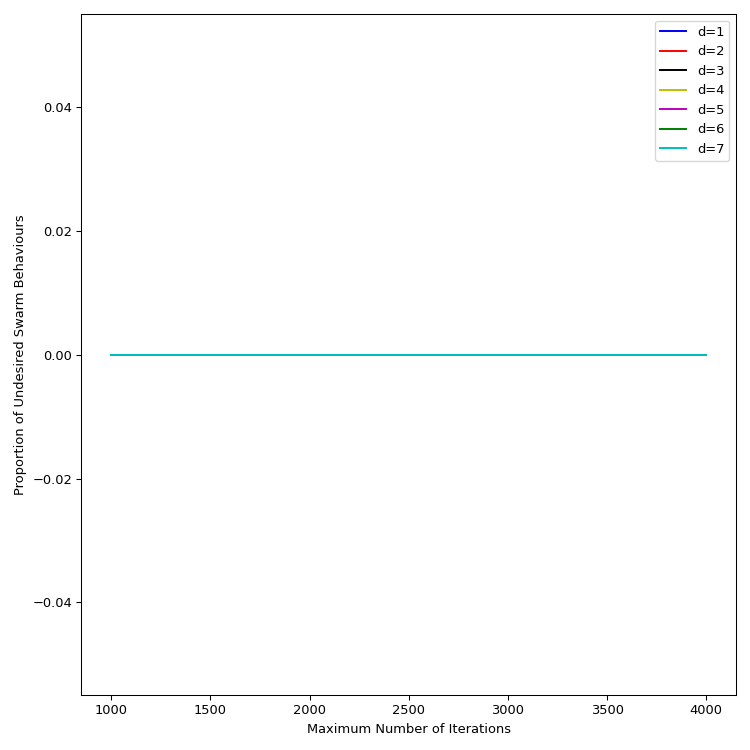

(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:xlabel='Maximum Number of Iterations', ylabel='Proportion of Undesired Swarm Behaviours'>)

In [71]:


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.plot([1000,2000,3000,4000], np.array(undesired)[:4], '-b', ms=15, label="d=1")#for dimension 1
ax.set_xlabel('Maximum Number of Iterations')
ax.set_ylabel('Proportion of Undesired Swarm Behaviours')

ax.plot([1000,2000,3000,4000], np.array(undesired)[4:8], '-r', ms=15, label="d=2")#for dimension 1


ax.plot([1000,2000,3000,4000], np.array(undesired)[8:12], '-k', ms=15, label="d=3")#for dimension 1


ax.plot([1000,2000,3000,4000], np.array(undesired)[12:16], '-y', ms=15, label="d=4")#for dimension 1


ax.plot([1000,2000,3000,4000], np.array(undesired)[16:20], '-m', ms=15, label="d=5")#for dimension 1


ax.plot([1000,2000,3000,4000], np.array(undesired)[20:24], '-g', ms=15, label="d=6")#for dimension 1


ax.plot([1000,2000,3000,4000], np.array(undesired)[24:28], '-c', ms=15, label="d=7")#for dimension 1


plt.legend(loc="best")
fig.tight_layout()
fig,ax

<IPython.core.display.Javascript object>


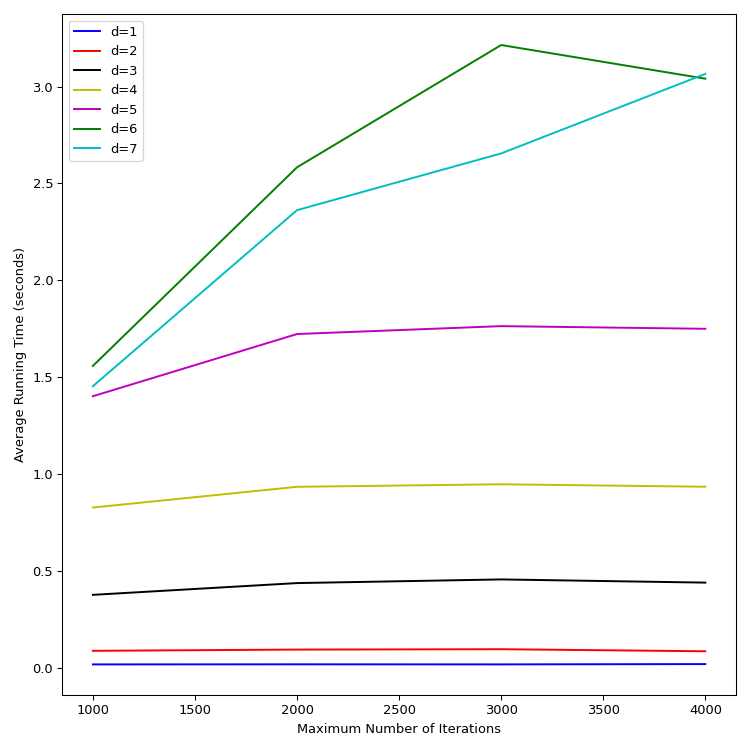

(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:xlabel='Maximum Number of Iterations', ylabel='Average Running Time (seconds)'>)

In [72]:

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.plot([1000,2000,3000,4000], np.array(seconds)[:4], '-b', ms=15, label="d=1")#for dimension 1
ax.set_xlabel('Maximum Number of Iterations')
ax.set_ylabel('Average Running Time (seconds)')

ax.plot([1000,2000,3000,4000], np.array(seconds)[4:8], '-r', ms=15, label="d=2")#for dimension 1


ax.plot([1000,2000,3000,4000], np.array(seconds)[8:12], '-k', ms=15, label="d=3")#for dimension 1


ax.plot([1000,2000,3000,4000], np.array(seconds)[12:16], '-y', ms=15, label="d=4")#for dimension 1


ax.plot([1000,2000,3000,4000], np.array(seconds)[16:20], '-m', ms=15, label="d=5")#for dimension 1


ax.plot([1000,2000,3000,4000], np.array(seconds)[20:24], '-g', ms=15, label="d=6")#for dimension 1


ax.plot([1000,2000,3000,4000], np.array(seconds)[24:28], '-c', ms=15, label="d=7")#for dimension 1


# ax.set_yscale(loc="best")
plt.legend(loc="best")
fig.tight_layout()
fig,ax